In [95]:
import open3d as o3d
import cv2
import sys
import numpy as np
import argparse
import math
import os
from pathlib import Path

In [96]:
sub_cnt, bin_cnt = '1', '01'
dir_path = '/home/ghosnp/dataset/cadc/data/000'+sub_cnt+'/labeled/lidar_points/data'
file_name = '00000000'+bin_cnt+'.bin'

# dir_path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1024_1907/vehicle.tesla.model3.master/test/velodyne'
# file_name = '000002.bin'

# dir_path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1019_2027/vehicle.tesla.model3.master/velodyne_CVL_beta_0.013/'
# file_name = '0000445520.bin'

pcd_path = os.path.join(dir_path, file_name)
pre_point = np.fromfile(str(pcd_path), dtype=np.dtype([
                                    ('x', np.float32),
                                    ('y', np.float32),
                                    ('z', np.float32),
                                    ('intensity', np.float32),
                                ]) ,count=-1)

pcd = np.array([list(elem) for elem in pre_point])


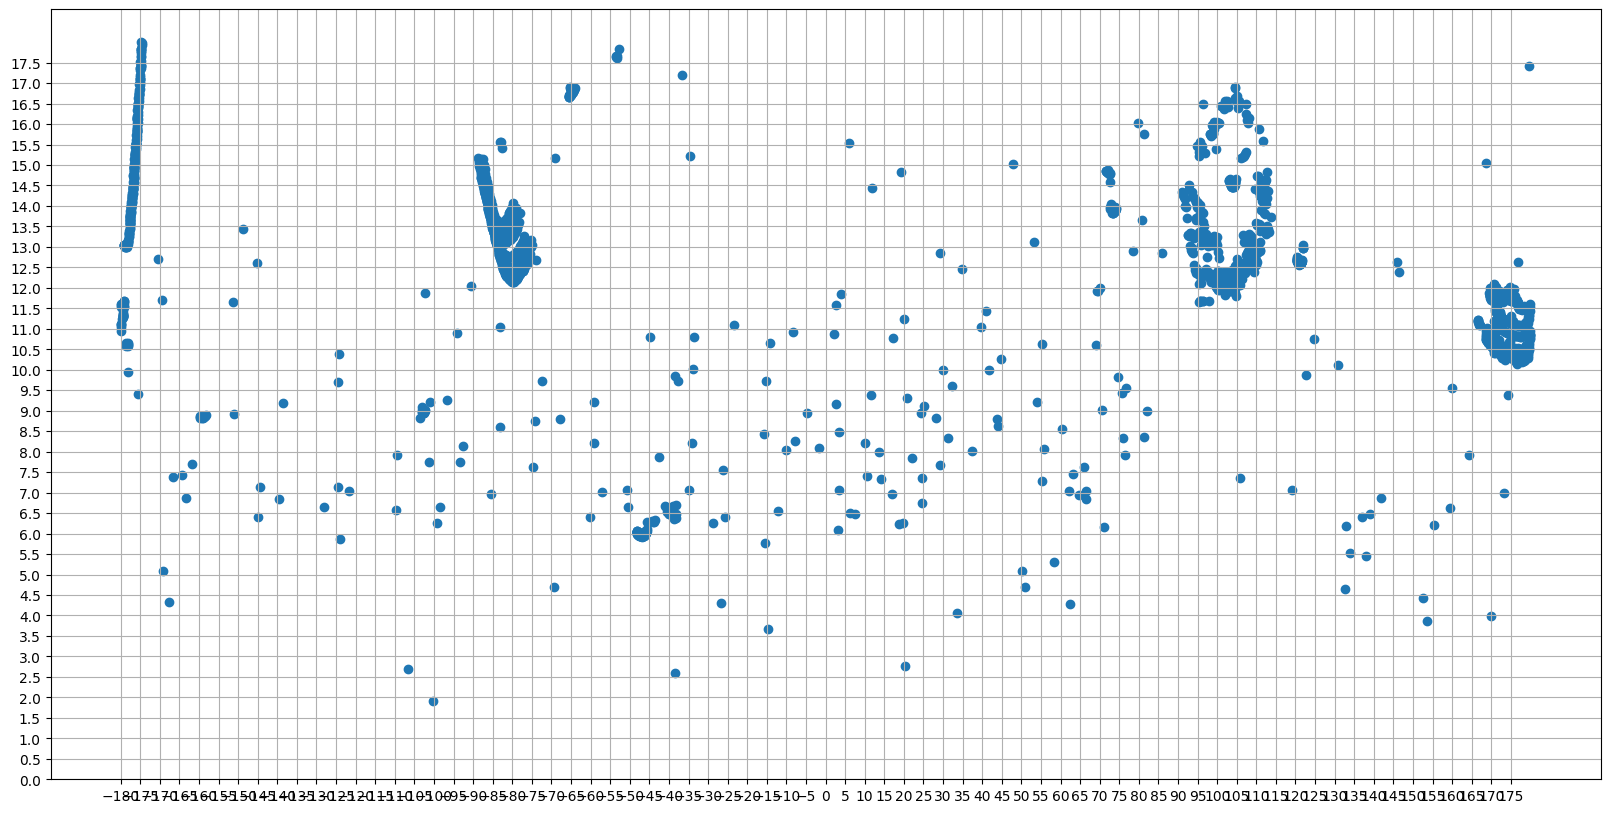

In [97]:
radius = 18
depth = -0.2

select_point = pcd[np.sqrt(pcd[:,0]**2 + pcd[:,1]**2) < radius]
select_point = select_point[select_point[:,2] > depth]

# make the selected point into a polar coordinate
theta = np.arctan2(select_point[:,1], select_point[:,0])
r = np.sqrt(select_point[:,0]**2 + select_point[:,1]**2)
# theta to degree
theta = theta*180/math.pi

# visualize the polar coordinate in a figure
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(theta, r)
plt.grid()
# set tick 
plt.xticks(np.arange(-180, 180, 5))
plt.yticks(np.arange(0, radius, 0.5))
plt.show()


Estimated number of clusters: 12
Silhouette Coefficient: 0.553


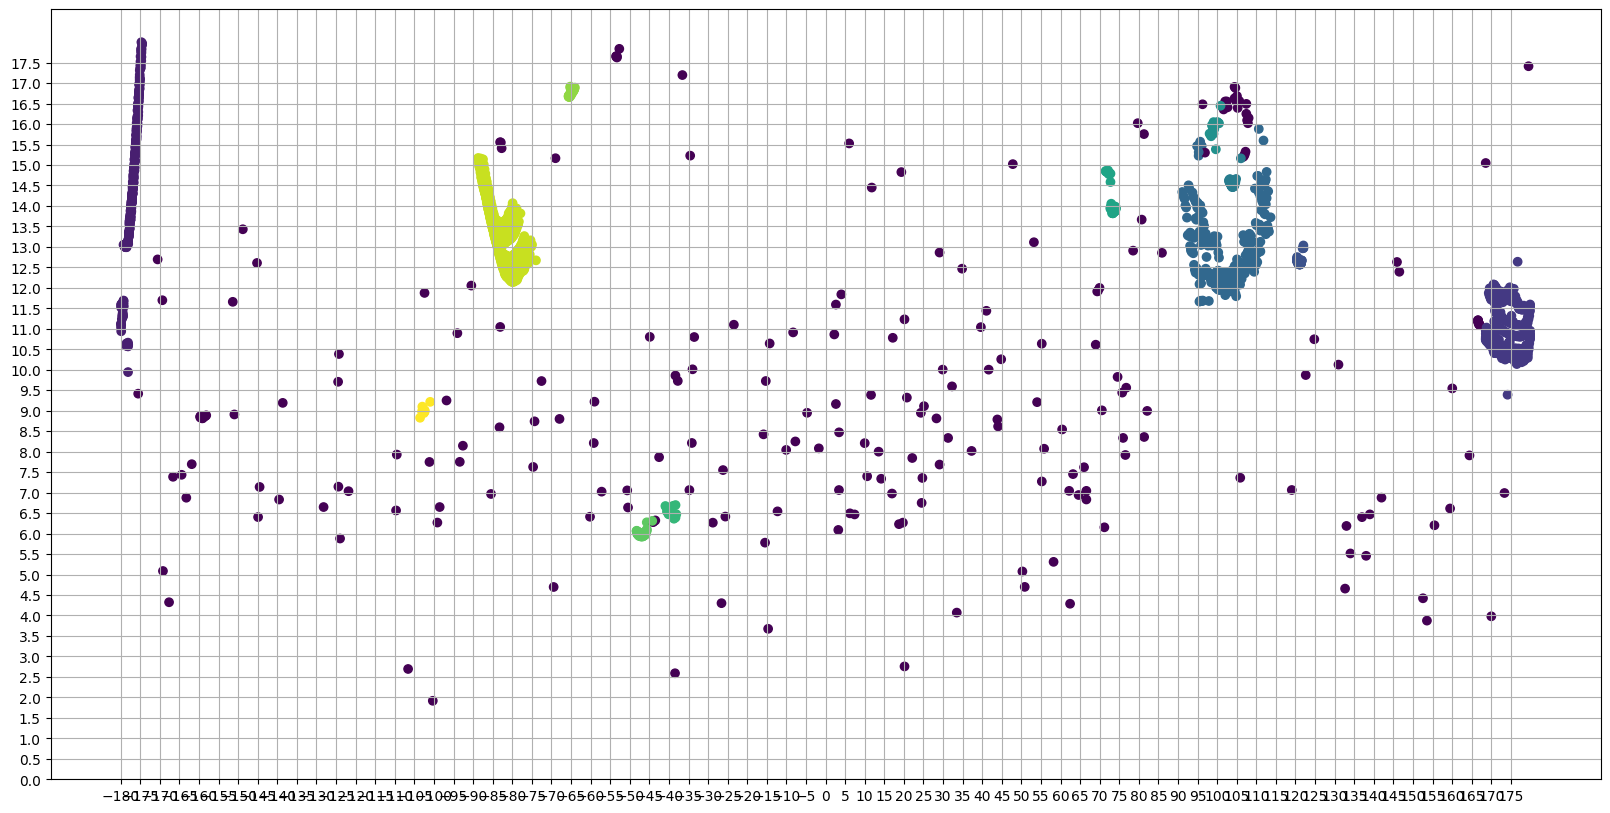

In [98]:
import sklearn.cluster as cluster
from sklearn import metrics

select_point_polar = np.array([theta, r]).T

# DBSCAN
#db = cluster.Birch(threshold=0.5, branching_factor=50, n_clusters=None).fit(select_point_polar[:,0:2])
db = cluster.DBSCAN(eps=1.5, min_samples=15).fit(select_point_polar[:,0:2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(select_point_polar[:,0:2], labels))

# show the result in a figure
plt.figure(figsize=(20,10))
plt.scatter(select_point_polar[:,0], select_point_polar[:,1], c=labels)
plt.xticks(np.arange(-180, 180, 5))
plt.yticks(np.arange(0, radius, 0.5))
plt.grid()
plt.show()

In [99]:
# make the point into grid, in x-y plane
grid_size = 0.2
grid_num = 2 * radius / grid_size
grid_num = int(grid_num)
grid_plane = np.zeros((grid_num, grid_num))
# the gird count the point in each grid
place = select_point[:,0:2] / grid_size
place = np.floor(place)
place = place.astype(int)
np.add.at(grid_plane, (place[:,0], place[:,1]), 1)

# calculate the variance of grid_plane
variance = np.var(grid_plane)
print('variance: ', variance)

variance:  1.1612126876619417


average: 0.2638888888888889


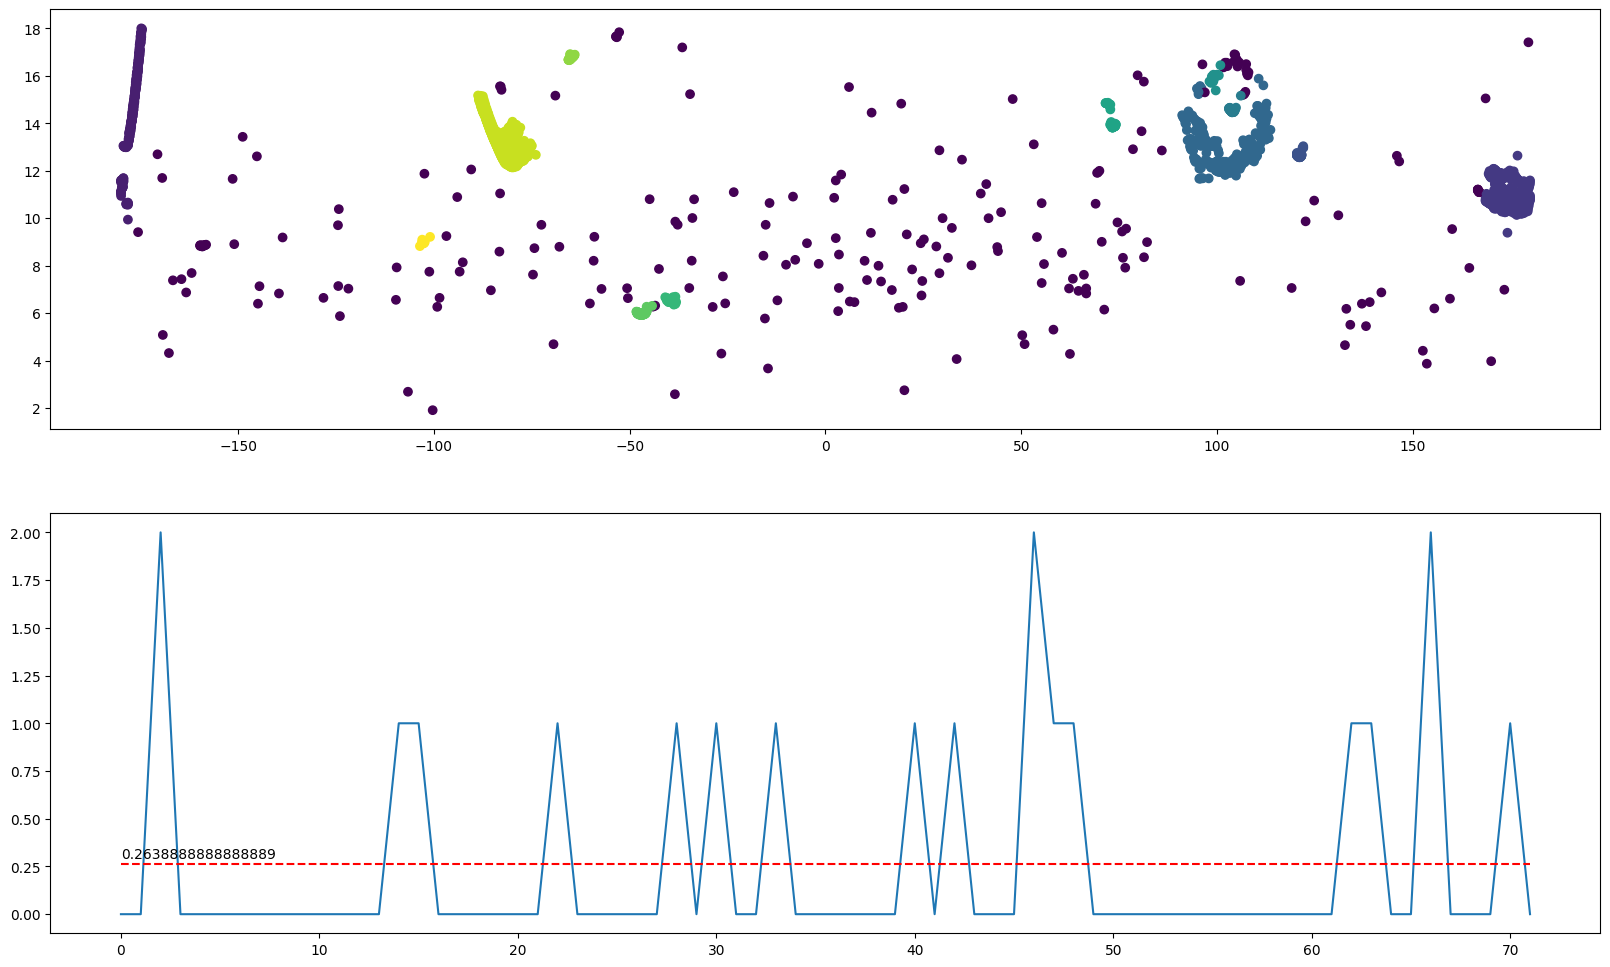

In [100]:
import sklearn.cluster as cluster
from sklearn import metrics

select_point_polar = np.array([theta, r]).T
# 网格化, theta:(-180, 180, 5), r:(0, radius, 0.5)
point_polar_block = np.zeros((int(360/5), int(radius/0.5)))
for i in range(select_point_polar.shape[0]):
    thetas = select_point_polar[i,0]
    rs = select_point_polar[i,1]
    theta_idx = int((thetas+180)/5)
    r_idx = int(rs/0.5)
    point_polar_block[theta_idx, r_idx] += 1

sum_block10 = np.zeros((72,1))
for i in range(72):
    sum_block10[i] = np.sum(point_polar_block[i,0:11])
print('average:', np.average(sum_block10))

# show the two figures in one
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20, 12))
ax1.scatter(select_point_polar[:,0], select_point_polar[:,1], c=labels)
ax2.plot(sum_block10)
ax2.plot(np.arange(0,72,1), np.ones((72,1))*np.average(sum_block10), 'r--')
ax2.text(0, np.average(sum_block10)*1.1, np.average(sum_block10))
# ax2.plot(np.arange(0,72,1), np.ones((72,1))*3, 'g--')
# ax2.text(0, 3.5, 3)
plt.show()

Text(0, 0.2902777777777778, '0.2638888888888889')

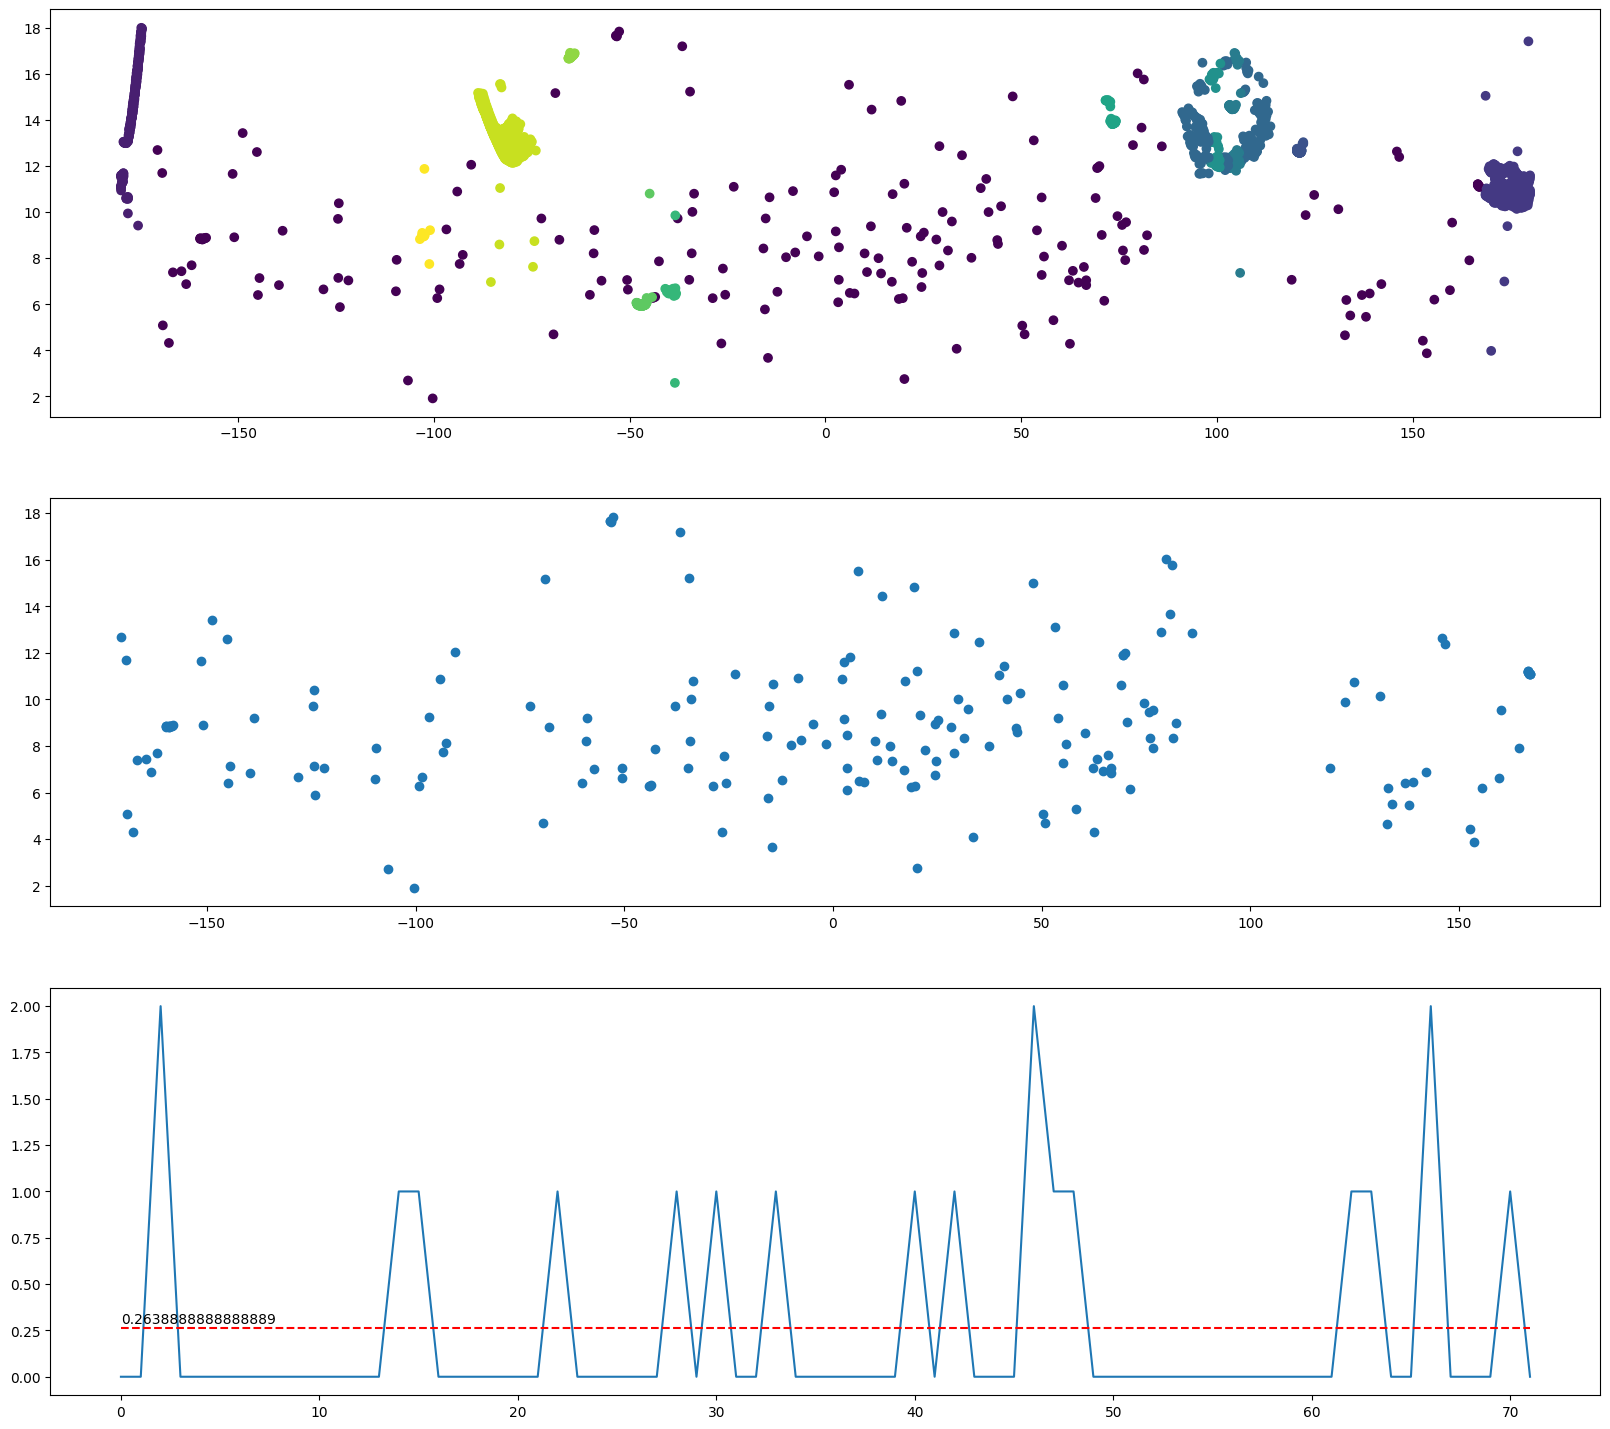

In [101]:
label_count = {}
label_point = {}
for i in range(n_clusters_):
    label_count[i] = np.sum(labels==i)
    label_point[i] = select_point_polar[labels==i]


label_range = {i: [np.min(label_point[i][:,0]), np.max(label_point[i][:,0])] for i in range(n_clusters_)}
label_range = sorted(label_range.items(), key=lambda x:x[1][0])

RANGE = 5
K = 0.5
# near_points = {-1:0}
# for i in range(select_point_polar.shape[0]):
#     theta, r = select_point_polar[i,0], select_point_polar[i,1]
#     Flag = False
#     for [k,v] in label_range:
#         if theta >= v[0] and theta <= v[1]:
#             if r < RANGE:
#                 near_points[k] = near_points.get(k, 0) + 1
#                 Flag = True
#                 break
#             else:
#                 labels[i] = k
#     if not Flag:
#         near_points[-1] += 1

near_points = {-1:0}
thetas,rs = select_point_polar[:,0], select_point_polar[:,1]

for [k,v] in label_range:
    mask = np.logical_and(thetas>=v[0], thetas<=v[1])
    near_points[k] = np.sum(rs[mask]<RANGE)
    labels[mask] = k
near_points[-1] = len(select_point_polar) - sum(near_points.values())


label_length = 0
label_rho = {}
label_length = {}
for k,v in near_points.items():
    temp_length = label_range[k][1][1] - label_range[k][1][0]
    label_rho[k] = v/temp_length
    label_length[k] = temp_length

origin_length = 360 - sum(label_length.values())
max_label = max(label_length.items(), key=lambda x:x[1]) 
if origin_length < max_label[1]:
    origin_length = max_label[1]
    label_rho.pop(max_label[0])
    near_points[-1] = near_points[max_label[0]]

base_rho = K * near_points[-1]/origin_length
drop_key = [k for k, v in label_rho.items() if v < base_rho]

indice = [i for i in range(select_point_polar.shape[0]) if labels[i] not in drop_key]
result_point_polar = select_point_polar[indice]


fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20, 18))
ax1.scatter(select_point_polar[:,0], select_point_polar[:,1], c=labels)
ax2.scatter(result_point_polar[:,0], result_point_polar[:,1])
ax3.plot(sum_block10)
ax3.plot(np.arange(0,72,1), np.ones((72,1))*np.average(sum_block10), 'r--')
ax3.text(0, np.average(sum_block10)*1.1, np.average(sum_block10))

Text(0.5, 0.98, 'valid length=273.57763671875')

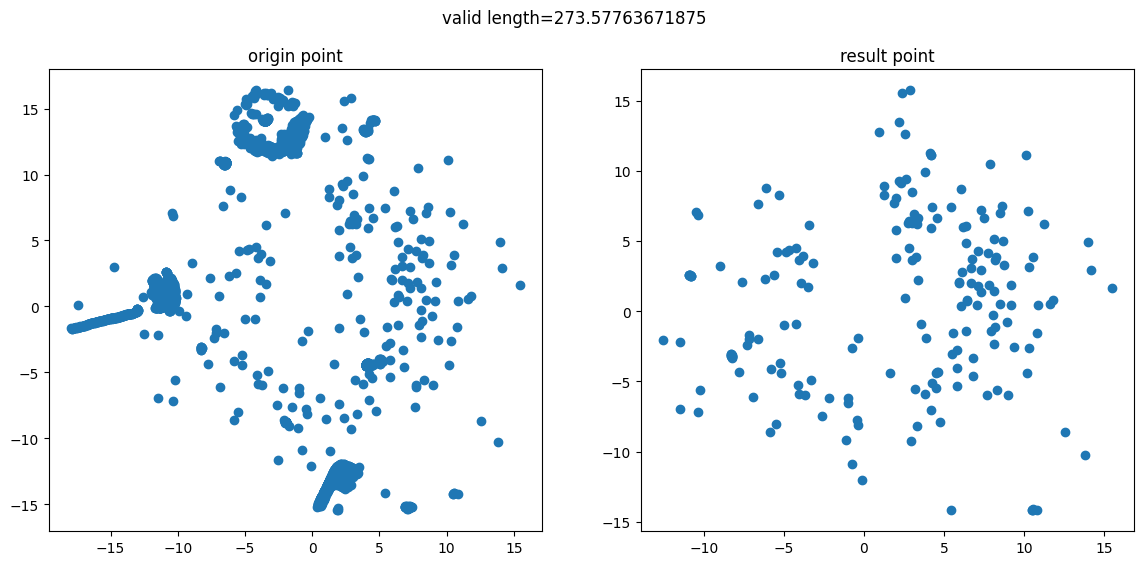

In [102]:
# 将result_point_polar转换为result_point
result_point = []
for i in range(result_point_polar.shape[0]):
    theta = result_point_polar[i,0]
    r = result_point_polar[i,1]
    x = r*math.cos(theta*math.pi/180)
    y = r*math.sin(theta*math.pi/180)
    result_point.append([x, y, 0])

result_point = np.array(result_point)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14, 6))
ax1.scatter(select_point[:,0], select_point[:,1])
ax1.set_title('origin point')
ax2.scatter(result_point[:,0], result_point[:,1])
ax2.set_title('result point')
# set figure title
fig.suptitle('valid length='+str(origin_length))

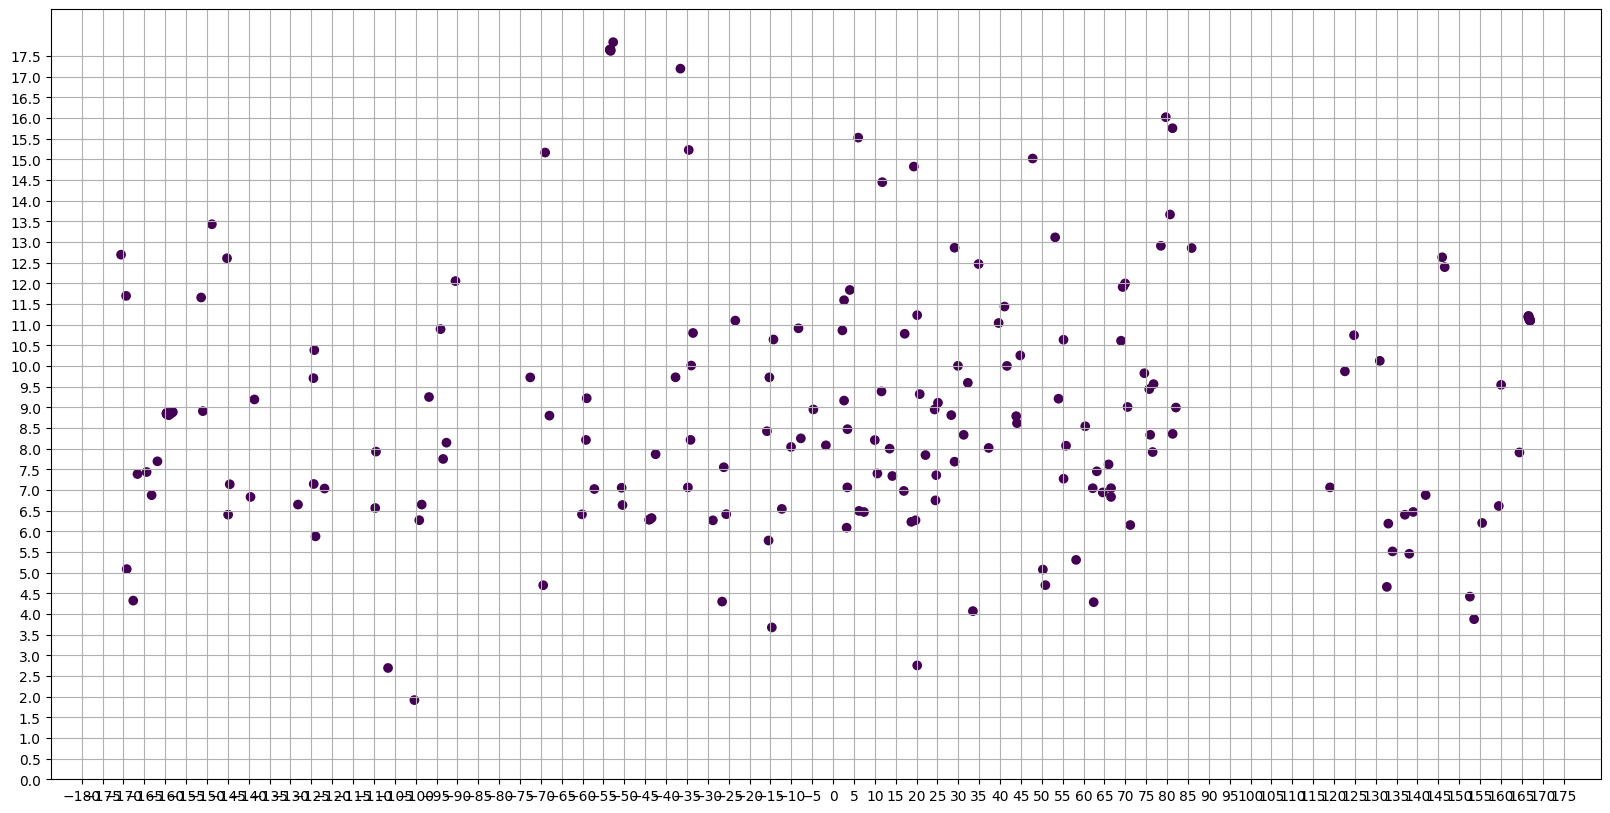

In [103]:
db.fit(result_point_polar[:,0:2])
labels = db.labels_
# visualize the polar coordinate in a figure
plt.figure(figsize=(20,10))
plt.scatter(result_point_polar[:,0], result_point_polar[:,1], c=labels)
plt.grid()
# set tick
plt.xticks(np.arange(-180, 180, 5))
plt.yticks(np.arange(0, radius, 0.5))
plt.show()



In [104]:
other_points = pcd[np.sqrt(pcd[:,0]**2 + pcd[:,1]**2) >= radius]
indice = [i for i in range(select_point_polar.shape[0]) if labels[i] in drop_key]
other_points = np.concatenate((other_points, select_point[indice]), axis=0)

sum_itensity_other = np.sum(other_points[:,3])
num_other = other_points.shape[0]
sum_itensity_all = np.sum(pcd[:,3])
num_all = pcd.shape[0]
num_result = result_point.shape[0]
sum_itensity_result = sum_itensity_all-sum_itensity_other

# drop the other_points[:3]==0
# indice = [i for i in range(other_points.shape[0]) if other_points[i,3]!=0]
# other_points = other_points[indice]
# other_points = other_points[other_points[:,3]>0]
# beta_other = -np.log(other_points[:,3]) / np.sqrt(other_points[:,0]**2+other_points[:,1]**2+other_points[:, 2]**2)
# aver_beta_other = np.sum(beta_other)/len(beta_other)
# print('aver_beta_other:', aver_beta_other)
pcd = pcd[pcd[:,3]>0]
beta_all = -np.log(pcd[:,3]) / np.sqrt(pcd[:,0]**2+pcd[:,1]**2+pcd[:, 2]**2)
aver_beta_all = np.sum(beta_all)/len(beta_all)
print('aver_beta_all:', aver_beta_all)



IndexError: index 193 is out of bounds for axis 0 with size 193